## 画像分類モデル

・ニューラルネットの構築
・Dataset,DataLoaderの読み込み
・分類タスクの損失

In [30]:
from torchvision import datasets

from matplotlib import pyplot as plt
import numpy as np
import torch

In [37]:
data_path = "../data/p1ch7/"
#引数は保存のパス、訓練用かテスト用か、pytorchで保存して良いか
#他にもSVHN ,COCO,Ominglotなどがある
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
#torch.util.data.datasetsのサブクラスとして返される
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

##datasetクラス

In [38]:
len(cifar10), len(cifar10_val)

(50000, 10000)

datasetはデータを保持している訳ではなく、__len__,__getitem__を介してデータへのアクセスを提供する

In [39]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [40]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

<function matplotlib.pyplot.show(close=None, block=None)>

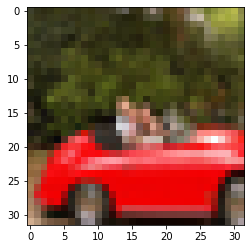

In [35]:
plt.imshow(img)
plt.show

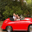

In [44]:
img

画像の変換はtorchvisionのtransforms

In [9]:
from torchvision import transforms
dir(transforms)

['AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [10]:
img_arr = np.array(img)
print(img_arr.shape)

(32, 32, 3)


In [11]:
#To.tensorではpil画像からテンソルへ変換できる
#一度インスタンス化してから引数に画像を入れる


from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)

print(f"変換後{img_t.shape}")

変換後torch.Size([3, 32, 32])


In [12]:
#datasetへの引数にもtransformsで渡せる
tensor_cifar10 = tensor_cifar10 = datasets.CIFAR10(data_path,
                                                  train=True,
                                                  download=False,
                                                  transform = transforms.ToTensor())

In [13]:
#pilではなくtensor
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [14]:
#0から１.0へのスケーリングもされる
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

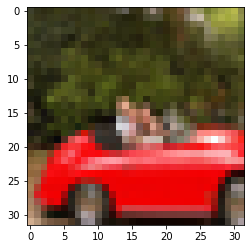

In [15]:
#img_tが元の画像なのか確認

plt.imshow(img_t.permute(1,2,0))
plt.show()

## データの正規化

In [19]:
tensor_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data/p1ch7/
    Split: Train
    StandardTransform
Transform: ToTensor()

transform.Composeを用いて複数の変換を繋げて行うことが可能。
正規化やデータ拡張がある
平均0、標準偏差1の正規化を行うことは良い習慣である

正規化を行う理由は
・データを一定の範囲に保ち、その範囲内（0＋ー1）で線形である活性化関数を選択すつことで、ニューロンが非0の可能性を上げる（訓練が速くなる）
・各チャネルを正規化することで、同じ学習率の使用ができる

平均値と標準偏差をあらかじめ計算しなければいけないがこの計算を、transform.Normalizeが行う


In [25]:
#viewの確認
points=torch.zeros(3,32,32,100)
points.shape

#全ての画像の平均をチャネルごとに行う
points.view(3,-1).shape, points.view(3, -1).mean(dim=1).shape

(torch.Size([3, 102400]), torch.Size([3]))

In [16]:
#CIFAR10がデータが小さく、メモリ内で処理する
#下記で全ての画像をまとめたテンソルを作り、
#imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
#imgs.view(3, -1).mean(dim=1)  # <1>
#imgs.view(3, -1).std(dim=1)

In [17]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [27]:
#ToTensorと合わせてtransformを作r,datasetsに組み込む

transformed_cifar10 = datasets.CIFAR10(
            data_path, train=True, download=False, 
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4915, 0.4823, 0.4468),
                                     (0.1470, 0.2435, 0.2626))
            ]))

In [46]:
img_t, _ = transformed_cifar10[99]
img_t.shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


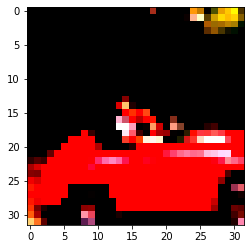

In [50]:
#RGBレベルが変化している。データとしては存在しておりmatplotlibが黒く表示している
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

##　画像分類モデル作成

飛行機と鳥の判別モデルを作る
ラベル「0」： airplane（飛行機）
ラベル「1」： automobile（自動車）
ラベル「2」： bird（鳥）
ラベル「3」： cat（猫）
ラベル「4」： deer（鹿）
ラベル「5」： dog（犬）
ラベル「6」： frog（カエル）
ラベル「7」： horse（馬）
ラベル「8」： ship（船）
ラベル「9」： truck（トラック）

In [59]:
#cifar10の中から飛行機と鳥のみのdatasetsにする

label_map = {0:0, 2:1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10 if label in [0,2]]

In [63]:
#データセットはdatasetsのサブクラスでなくても、getitemとlenメソッドが定義されていれば利用できる
type(cifar2[1]), type(cifar2)

(tuple, list)

全結合のモデルを試す

In [77]:
img,label = cifar2[1]
img_t = to_tensor(img).view(1,-1)
img_t.shape

torch.Size([1, 3072])

In [79]:
import torch.nn as nn
n_out = 2

model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Linear(512, n_out)
        )

今回は分類問題である。
ネットワーク上では１.0か０.０に対応させる。出力は鳥か飛行機二つのラベルであるため、ワンホットエンコーディングの表現に切り替える

CIFAR10の10カテゴリでも同様に可能であり、その時は長さが10のベクトルになる


モデルの出力の理想は飛行機はtorch.tensor([1.0、 0.0]),鳥の場合はtorch.tensor([0.0, 1.0])である。

実際にはその間の値が出力されることが予想される。
この値は0から1なので確率として解釈できる（出力の一番目が飛行機の確率、二番目が鳥の確率）

問題は出力の各値が0から1であること、二つの合計が1であること

この問題の解決策がsoftmax